# LINEAR MODEL
## Lasso model selection: AIC-BIC / cross-validation - [source](https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#sphx-glr-auto-examples-linear-model-plot-lasso-model-selection-py)

In [17]:
import time
import sklearn

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import (
    LassoLarsIC,
    LassoLarsCV,
    LassoCV
)

from sklearn.datasets import load_diabetes

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from scipy import sparse
# from scipy import ndimage
# from sklearn.linear_model import Lasso
# from sklearn.linear_model import Ridge


### Set global scikit-learn configuration

In [2]:
sklearn.set_config(display="diagram")

### Dataset

In [3]:
X, y = load_diabetes(return_X_y=True, as_frame=True)

X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


In [4]:
# In addition, we add some random features to the original data to better illustrate the feature selection performed by the Lasso model.
rng = np.random.RandomState(42)
n_random_features = 14

X_random = pd.DataFrame(
    rng.randn(X.shape[0], n_random_features),
    columns=[f"random_{i:02d}" for i in range(n_random_features)],
)

X = pd.concat([X, X_random], axis=1)

# Show only a subset of the columns
X[X.columns[::3]].head()

,age,bp,s3,s6,random_02,random_05,random_08,random_11
0,0.038076,0.021872,-0.043401,-0.017646,0.647689,-0.234137,-0.469474,-0.465730
1,-0.001882,-0.026328,0.074412,-0.092204,-1.012831,-1.412304,0.067528,0.110923
2,0.085299,-0.005671,-0.032356,-0.025930,-0.601707,-1.057711,0.208864,0.196861
3,-0.089063,-0.036656,-0.036038,-0.009362,-1.478522,1.057122,0.324084,0.611676
4,0.005383,0.021872,0.008142,-0.046641,0.331263,-0.185659,0.812526,1.003533


### Selecting Lasso via an information criterion

**Fit a Lasso model with the AIC criterion**

In [5]:
start_time = time.time()

lasso_lars_ic = make_pipeline(
    StandardScaler(), LassoLarsIC(criterion="aic", normalize=False)
).fit(X, y)

fit_time = time.time() - start_time

In [6]:
results = pd.DataFrame(
    {
        "alphas": lasso_lars_ic[-1].alphas_,
        "AIC criterion": lasso_lars_ic[-1].criterion_,
    }
).set_index("alphas")
alpha_aic = lasso_lars_ic[-1].alpha_

**Fit a Lasso model with the BIC criterion**

In [7]:
lasso_lars_ic.set_params(lassolarsic__criterion="bic").fit(X, y)
results["BIC criterion"] = lasso_lars_ic[-1].criterion_
alpha_bic = lasso_lars_ic[-1].alpha_

**Check which value of alpha leads to the minimum AIC and BIC**

In [9]:
def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]

results.style.apply(highlight_min)

,AIC criterion,BIC criterion
alphas,,
45.16003002046289,5244.765686,5244.765686
42.300447976855814,5208.252839,5212.344149
21.542302256518873,4928.021378,4936.203998
15.034109542941774,4869.678327,4881.952257
6.189693385716009,4815.437203,4831.802443
5.329589710548938,4810.422702,4830.879251
4.305929807780822,4803.572132,4828.119992
4.124324661267887,4804.126582,4832.765751
3.820655983805918,4803.620474,4836.350953


**Plot the AIC and BIC values for the different alpha values**

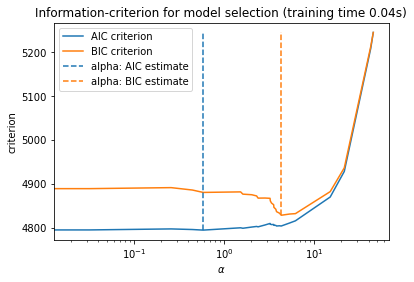

In [12]:
ax = results.plot()

ax.vlines(
    alpha_aic,
    results["AIC criterion"].min(),
    results["AIC criterion"].max(),
    label="alpha: AIC estimate",
    linestyles="--",
    color="tab:blue",
)

ax.vlines(
    alpha_bic,
    results["BIC criterion"].min(),
    results["BIC criterion"].max(),
    label="alpha: BIC estimate",
    linestyle="--",
    color="tab:orange",
)

ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("criterion")
ax.set_xscale("log")
ax.legend()
_ = ax.set_title(
    f"Information-criterion for model selection (training time {fit_time:.2f}s)"
)

### Selecting Lasso via cross-validation

**Lasso via coordinate descent**

In [15]:
start_time = time.time()
model = make_pipeline(StandardScaler(), LassoCV(cv=20)).fit(X,y)
fit_time = time.time() - start_time

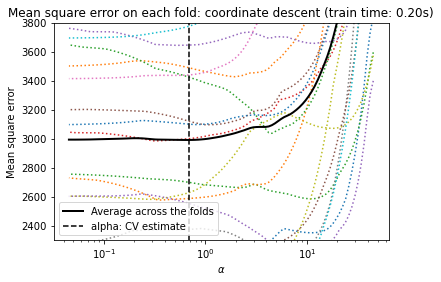

In [25]:
ymin, ymax = 2300, 3800
lasso = model[-1]

plt.semilogx(lasso.alphas_, lasso.mse_path_, linestyle=":")

plt.plot(
    lasso.alphas_,
    lasso.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)

plt.axvline(lasso.alpha_, linestyle="--", color="black", label="alpha: CV estimate")

plt.ylim(ymin, ymax)
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
plt.title(f"Mean square error on each fold: coordinate descent (train time: {fit_time:.2f}s)")

plt.show()

**Lasso via least angle regression**

In [27]:
start_time = time.time()
model = make_pipeline(StandardScaler(), LassoLarsCV(cv=20, normalize=False)).fit(X, y)
fit_time = time.time() - start_time

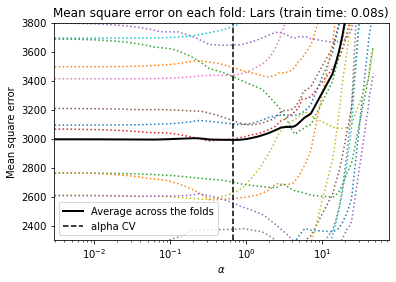

In [28]:
lasso = model[-1]
plt.semilogx(lasso.cv_alphas_, lasso.mse_path_, ":")

plt.semilogx(
    lasso.cv_alphas_,
    lasso.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)

plt.axvline(lasso.alpha_, linestyle="--", color="black", label="alpha CV")

plt.ylim(ymin, ymax)
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
plt.title(f"Mean square error on each fold: Lars (train time: {fit_time:.2f}s)")

plt.show()